In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
import torch
from torchvision import datasets as dset
from torchvision import transforms

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='/content/gdrive/MyDrive/processed_celeba_small/'):
    dataset = dset.ImageFolder(root=data_dir,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.ToTensor(),
                               ]))
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)
    
    return data_loader

In [ ]:
batch_size = 16
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

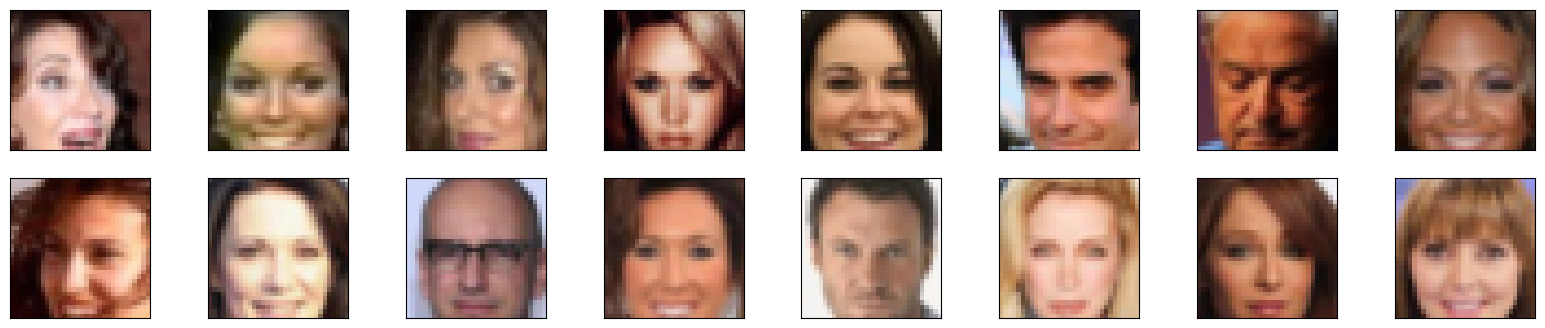

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = next(dataiter) 


fig = plt.figure(figsize=(20, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
def scale(x, feature_range=(-1, 1)):
    return x * (feature_range[1] - feature_range[0]) + feature_range[0]

In [ ]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(1.)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.fc = nn.Linear(128*8*2*2, 1)
  def forward(self, x):
      out = self.model(x)
      out = out.view(-1, 128*8*2*2)
      out = self.fc(out)
      return out      

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
    self.fc = nn.Linear(100, 128*8*2*2)
  def forward(self, x): 
      out = self.fc(x)
      out = out.view(-1, 128*4*2, 2, 2)
      out = self.model(out)
      return out          

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
def build_network():

    G = Generator()
    D = Discriminator()

    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [ ]:
z_size = 100

D, G = build_network()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (model): Sequential(
    (0): ConvTranspose

In [ ]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [ ]:
def real_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [ ]:
import torch.optim as optim
optimizer_D = optim.Adam(D.parameters(),0.0002, betas=(0.2, 0.999))
optimizer_G = optim.Adam(G.parameters(),0.0004, betas=(0.2, 0.999))


In [ ]:
def train(D, G, n_epochs, print_every=50):
    
    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            #print("D Input Real size:", real_images.size())
            real_images = scale(real_images)

            optimizer_D.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            #print("D Input size:", real_images.size())
            d_real = D(real_images)
            #print("D Output size:", d_real.size()) 
            d_real_loss = real_loss(d_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()

            #print("G Input size:", z.size()) 
            fake_images = G(z)
            
            #print("G Output size:", fake_images.size()) 
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake)
            
            g_loss.backward()
            optimizer_G.step()
         

            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | Batch:{:5d} | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, batch_i+1, d_loss.item(), g_loss.item()))


        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open('/content/gdrive/MyDrive/generated_faces_4/train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [ ]:
n_epochs = 50
print("Train on GPU:", train_on_gpu)
print("Batch Size:", batch_size, "Z_size:", z_size)
losses = train(D, G, n_epochs=n_epochs, print_every=50)

Train on GPU: True
Batch Size: 16 Z_size: 100
Epoch [    1/   50] | Batch:    1 | d_loss: 1.4518 | g_loss: 2.7161
Epoch [    1/   50] | Batch:   51 | d_loss: 0.8065 | g_loss: 3.4458
Epoch [    1/   50] | Batch:  101 | d_loss: 1.2316 | g_loss: 0.7879
Epoch [    1/   50] | Batch:  151 | d_loss: 0.9816 | g_loss: 1.2398
Epoch [    1/   50] | Batch:  201 | d_loss: 1.2281 | g_loss: 1.8386
Epoch [    1/   50] | Batch:  251 | d_loss: 1.2215 | g_loss: 1.6045
Epoch [    1/   50] | Batch:  301 | d_loss: 1.6197 | g_loss: 3.3049
Epoch [    1/   50] | Batch:  351 | d_loss: 1.2223 | g_loss: 1.2530
Epoch [    1/   50] | Batch:  401 | d_loss: 1.4718 | g_loss: 1.5871
Epoch [    1/   50] | Batch:  451 | d_loss: 1.1158 | g_loss: 1.1373
Epoch [    1/   50] | Batch:  501 | d_loss: 1.3206 | g_loss: 1.7533
Epoch [    1/   50] | Batch:  551 | d_loss: 1.3289 | g_loss: 1.0815
Epoch [    1/   50] | Batch:  601 | d_loss: 1.3934 | g_loss: 1.0714
Epoch [    1/   50] | Batch:  651 | d_loss: 1.4767 | g_loss: 1.0005
Ep

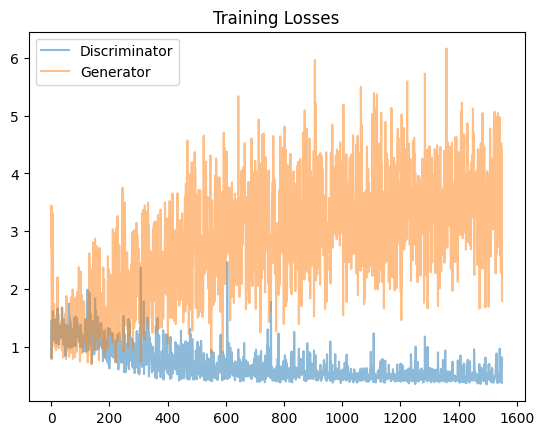

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend();

In [ ]:
import os
import cv2
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
with open('/content/gdrive/MyDrive/generated_faces_4/train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
from PIL import Image
epoch = 0
for sample in samples:
  epoch = epoch + 1
  count = 1
  for img in sample:
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img + 1)*255 / (2)).astype(np.uint8)
    im = Image.fromarray(img, "RGB")
    im = im.resize((128,128))
    numberImage = "epoch_" + str(epoch) + "_image_" + str(count) + ".png"
    path = os.path.join('/content/gdrive/MyDrive/generated_faces_4/faces/', numberImage)
    im.save(path)
    count = count + 1


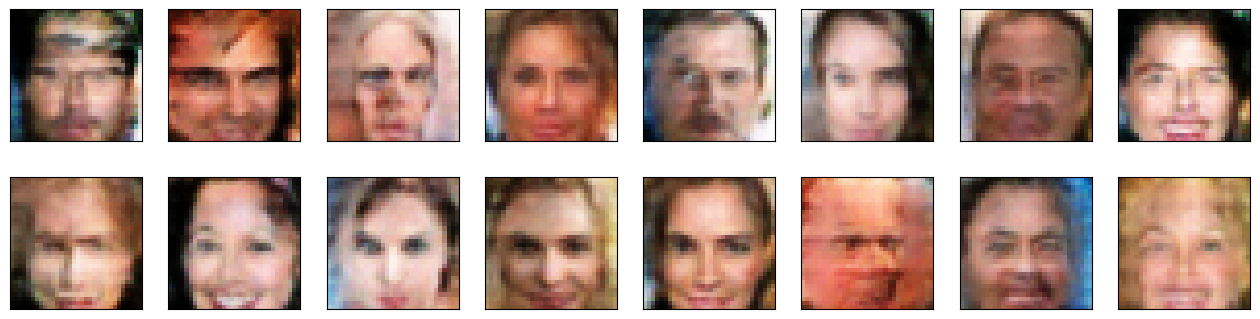

In [ ]:
_ = view_samples(1, samples)